In [1]:
using PyPlot, DataFrames
using Statistics, LsqFit

In [2]:
function lattice_adj(W, L)    
    adj = fill(fill((0,0),4), W, L)
    for w in 1:W, l in 1:L
        adj[w,l] = [
            (mod1(w+1, W), l),
            (mod1(w-1+W, W), l),
            (w, mod1(l+1, L)),
            (w, mod1(l-1+L, L))
        ]
    end
    return adj
end

lattice_adj (generic function with 1 method)

In [3]:
Adj = typeof(lattice_adj(2,2))
SiteSet = Set{Tuple{Int,Int}}

Set{Tuple{Int64, Int64}}

I like recursion.

It is not obvious that this is the fastest way to do it. An iterative algorithm may incur less overhead, but that is probably highly implementation-dependent.

In [4]:
function flip_from(conf::Matrix{Int}, pconn::Float64,
        adj::Adj, visited::SiteSet, cluster::SiteSet, w::Int, l::Int)
    push!(visited, (w,l))
    push!(cluster, (w,l))
    
    for neighbor in adj[w,l]
        if !(neighbor in visited)
            push!(visited, neighbor)
            if conf[w,l] == conf[neighbor...] && rand() < pconn
                push!(cluster, neighbor)
                flip_from(conf, pconn, adj, visited, cluster, neighbor...)
            end
        end
    end
end

function flip_cluster(conf::Matrix{Int}, pconn::Float64, adj::Adj)
    W,L = size(conf)
    visited = SiteSet()
    cluster = SiteSet()
    
    w, l = rand(1:W), rand(1:L)
    
    flip_from(conf, pconn, adj, visited, cluster, w, l)
    
    for wl in cluster
        conf[wl...] *= -1
    end
    
    return cluster
end

flip_cluster (generic function with 1 method)

Let's check that this does the right thing.

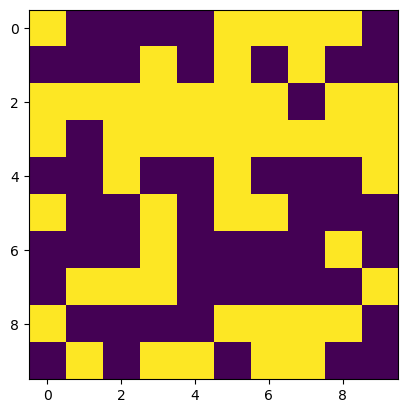

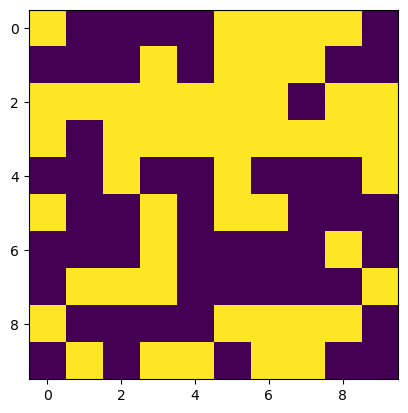

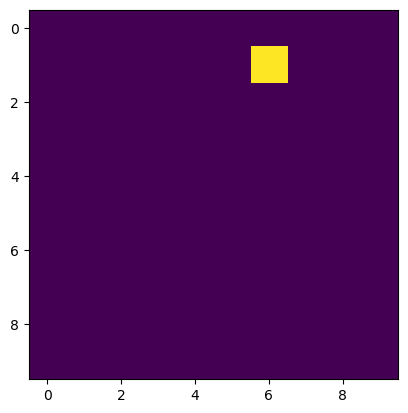

PyObject <matplotlib.image.AxesImage object at 0x2b1f4d678e80>

In [5]:
let
    L = 10
    adj = lattice_adj(L, L)
    ising_spins = rand([-1,1], L, L)

    imshow(ising_spins)
    cluster = flip_cluster(ising_spins, 1.0, adj)

    ref_conf = zeros(L, L)
    for (w,l) in cluster
        ref_conf[w,l] = 1
    end

    figure()
    imshow(ising_spins)

    figure()
    imshow(ref_conf)
end

In [6]:
df = DataFrame(L=Int[], p=Float64[], c_mean=Float64[], c_std=Float64[])

let
    for L in 50:10:100
        adj = lattice_adj(L, L)
        ising_spins = rand([-1,1], L, L)

        for p in 0.6:0.01:0.9
            y = Float64[]
            for step in 1:1000
                cluster = flip_cluster(ising_spins, p, adj)
                if step > 500
                    push!(y, length(cluster))
                end
            end

            push!(df, [L, p, mean(y), std(y)])
        end
    end
end

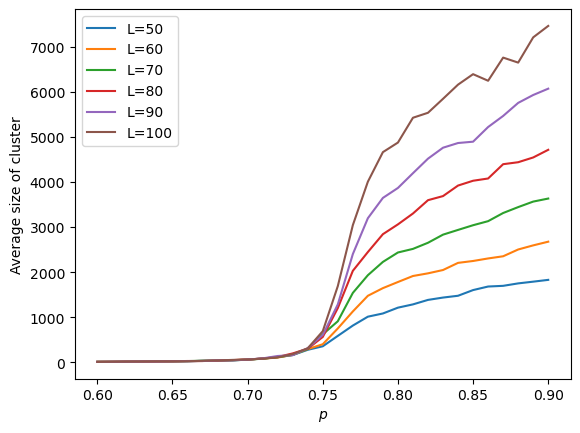

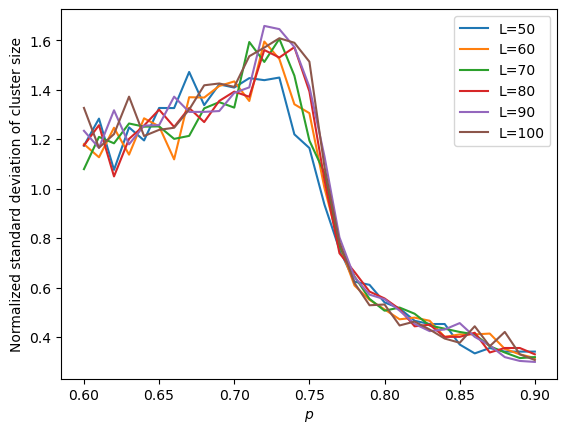

PyObject Text(24.000000000000014, 0.5, 'Normalized standard deviation of cluster size')

In [9]:
for subdf in groupby(df, :L)
    figure(1)
    plot(subdf[!,:p], subdf[!,:c_mean], label="L=$(subdf[1,:L])")
    
    figure(2)
    plot(subdf[!,:p], subdf[!,:c_std] ./ subdf[!,:c_mean], label="L=$(subdf[1,:L])")
end

figure(1)
legend()
xlabel(L"p")
ylabel("Average size of cluster")

figure(2)
legend()
xlabel(L"p")
ylabel("Normalized standard deviation of cluster size")